# Submission for Cats vs Dogs redux

This code does the following:

1. Load a pre-trained VGG16 model
2. Finetune the model so that it detects only two classes: cats and dogs, using the information from the competition
3. Predict the data in the /test folder
4. Output and submit to kaggle

One minor thing that I do is modify the VGG script so that there is an option for autogenerating the validation sample without having to do it manually, while at the same time keeping the code compatible with the other notebooks I have

## Task 1: Divide the dataset in cats/dogs and create a samples folder

In [32]:
import os
import shutil
import sklearn
path="kaggle_dogs/"
path=os.path.realpath('')+'/'+path
# cats/dogs
pre_run=0
samplesize=50
prop_train=0.75
ncats=0
ndogs=0
if(pre_run==1):
    shutil.rmtree(path+'train',ignore_errors=True)
    shutil.rmtree(path+'sample',ignore_errors=True)
    os.makedirs(path+'train/dogs',exist_ok=True)
    os.makedirs(path+'train/cats',exist_ok=True)
    os.makedirs(path+'valid/dogs',exist_ok=True)
    os.makedirs(path+'valid/cats',exist_ok=True)
    os.makedirs(path+'sample/train/cats',exist_ok=True)
    os.makedirs(path+'sample/train/dogs',exist_ok=True)
    os.makedirs(path+'sample/valid/cats',exist_ok=True)
    os.makedirs(path+'sample/valid/dogs',exist_ok=True)
    os.makedirs(path+'sample/test',exist_ok=True)
    from sklearn.model_selection import train_test_split
    train,valid=train_test_split(os.listdir(path+'train_orig/'),train_size=prop_train,random_state=42)
    print('We got here')     
    for file in train:
            filepath=path+'train_orig'+'/'+file
            if(file.startswith('dog.')):
                shutil.copy(filepath,path+'train/dogs')
                if(ndogs<=samplesize*prop_train):
                    shutil.copy(filepath,path+'sample/train/dogs')
                    ndogs+=1
            elif(file.startswith('cat.')):
                shutil.copy(filepath,path+'train/cats')
                if(ncats<=samplesize*prop_train):
                    shutil.copy(filepath,path+'sample/train/cats')
                    ncats+=1
    ndogs=0
    ncats=0
    print('We got here')
    for file in valid:
            filepath=path+'train_orig'+'/'+file        
            if(file.startswith('dog.')):
                shutil.copy(filepath,path+'valid/dogs')
                if(ndogs<=samplesize*(1-prop_train)):
                    shutil.copy(filepath,path+'sample/valid/dogs')
                    ndogs+=1
            elif(file.startswith('cat.')):
                shutil.copy(filepath,path+'valid/cats')
                if(ncats<=samplesize*(1-prop_train)):
                    shutil.copy(filepath,path+'sample/valid/cats')
                    ncats+=1
    ntest=0     
    test_files=os.listdir(path+'test')
    print('We got here')
    for file in test_files:
        filepath=path+'test'+'/'+file
        shutil.copy(filepath,path+'sample/test')
        ntest+=1
        if(ntest>=20):
            break
        


We got here


KeyboardInterrupt: 

## Task 2:Use the VGG16 model

In [5]:
import vgg16
from vgg16 import Vgg16
#This utils is from the fast.ai course
import utils
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from utils import plots
%matplotlib inline
vgg=Vgg16()
path='kaggle_dogs/sample/'
# 64 for good GPUs, 32 for bad ones
batch_size=32
#training batches
batches=vgg.get_batches(batch_size=batch_size,path=path+'train')
val_batches=vgg.get_batches(batch_size=batch_size*2,path=path+'valid')

Found 76 images belonging to 2 classes.
Found 26 images belonging to 2 classes.


Found 76 images belonging to 2 classes.


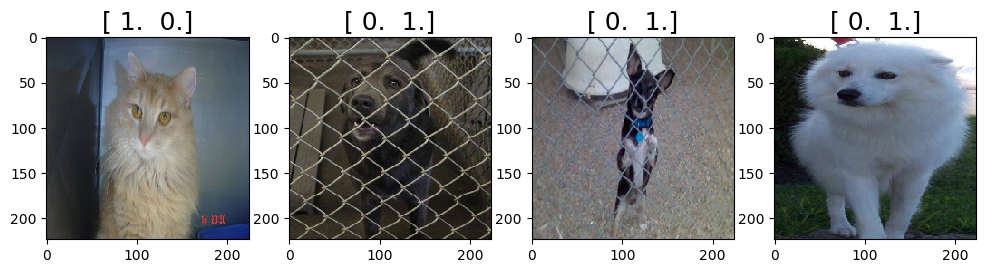

In [6]:
batches = vgg.get_batches(path+'train', batch_size=4)
imgs,labels = next(batches)
#Here 01 means dog, 10 means cat
plots(imgs, titles=labels)

In [7]:
#We first get predictions with the default model
vgg.predict(imgs, True)

(array([ 0.1147,  0.1407,  0.1516,  0.4268], dtype=float32),
 array([283, 276, 158, 258]),
 ['Persian_cat', 'hyena', 'toy_terrier', 'Samoyed'])

Now I finetune the model so that it only discriminates between cats and dogs

In [9]:
vgg.finetune(batches)
nb_epoch = 6
history=vgg.fit(batches, val_batches, nb_epoch=nb_epoch)

Epoch 1/6
76/76 [==============================] - 5s - loss: 0.8177 - acc: 0.7632 - val_loss: 0.1336 - val_acc: 0.9231

In [ ]:
import matplotlib.pyplot as plt
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

Let's try predicting now

In [ ]:
print(vgg.predict(imgs, all_probs=True))
#Labels are wrong, but here 0 means cat and 1 means dog

Now we can predict on the test dataset and submit to kaggle

In [ ]:
print(imgs.shape)
path="kaggle_dogs/test/"
from keras.preprocessing import image
img_list=os.listdir(path)
#Int is better for memory... but it won't work because then this will probably generate problems with other ops
#Sad!
test_imgs=np.empty((len(img_list),3,224,224))
labels=[]
for i,img in enumerate(img_list):    
    labels.append(img.split('.')[0])

In [ ]:
def write_tofile():
    test_imgs=np.empty((1,3,224,224))
    import tqdm
    from tqdm import tqdm
    to_write=''
    with open('submission.csv','w') as f:
            f.write('id,label\n')
            j=0
            for img in tqdm(img_list):
                test_imgs=image.img_to_array(image.load_img(path+img, target_size=(224, 224)))
                prob_dog=vgg.predict(test_imgs.reshape(1,3,224,224), all_probs=True)[3][:,1][0]
                i=labels[j]
                to_write+=i+','+str(prob_dog)+'\n'
                j+=1
            f.write(to_write)


In [ ]:
import pandas as pd
import numpy as np
sub=pd.read_csv('submission.csv')
sub.sort_values(by='id',inplace=True)
sub.index = np.arange(1, len(sub) + 1)
sub.drop('id',inplace=True,axis=1)
sub.index.name='id'

sub.loc[sub.label>0.99,'label']=0.99
sub.loc[sub.label<0.01,'label']=0.01
sub.to_csv('submission_sorted.csv')
sub.head()

The default scores, after about 6 epochs, gave a public score that ranked me in the  upper 57% of the competition. By clipping the scores I managed to bring it down even more and now I'm in the top 24%. So I've officially finished :)

In [ ]:
# Submit to kaggle
import os
#os.system('kg submit submission_sorted.csv')

In [31]:
test_batches = vgg.get_batches('kaggle_dogs/sample/pretest', shuffle=False, batch_size=8, class_mode=None)

Found 20 images belonging to 1 classes.
